#  <div align="center"> Generating Predictions for Silk Road Addresses from AUG - SEPT 2013 </div>
### <div align="right">Date : 04/23/2017</div>
## <div align="left"> Team :
    Abhinav Pathak
    Jayanti Trivedi
    Kunal Anil Wagh
    Kushal Chandra
    Shishir Shirbhate
    Surya Narayana Kalipattapu
</div>

# Table of Content
###  1 . [Loading Packages](#sec1)
> #### 1.1 . [Installing packages](#sec1.1)
> #### 1.2 . [Packages for running pypark local](#sec1.2)
> #### 1.3 . [Packages for running pypark on AWS](#sec1.2)

###  2 . [Loading the data](#sec2)
> #### 2.1 . [Loading the silk road address interaction data for Aug - Spet 2013](#sec2.1)
> #### 2.2 . [Loading the silk road address data with flag for Aug - Spet 2013](#sec2.2)
> #### 2.3 . [Creating features for the sender-receiver interaction data](#sec2.3)
>> ##### 2.3.1 . [Creating address level features like in_degree , out_degree , mean_bitcoin_value and mean_time](#sec2.3.1)
>> ##### 2.3.2 . [Creating network level features clustering coeffecient and PageRank](#sec2.3.2)
>> ##### 2.3.3 . [Model building with Machine Learning algorithm](#sec2.3.3)
>> ##### 2.3.4 . [Model output with Graphlab](#sec2.3.4)
>> ##### 2.3.5 . [Model output with Plotly](#sec2.3.5)

### 3 . [Generating test data](#sec3)

###  4 . [Logistic Regression Model](#sec4)
> #### 4.1 . [Importing the pyspark package for logistic regression and data normalization](#sec4.1)
> #### 4.2 . [Creating the features and labels as dense vectors and running the logistic regression model](#sec4.2)
> #### 4.3 . [Output of logistic regression model](#sec4.3)
> #### 4.4 . [Testing the model](#sec4.4)

<a id='sec1'></a>
## 1. Loading the necessary packages

<a id='sec1.1'></a>
### 1.1 Installing packages

In [ ]:
# Remove the hash and run the scipt if the package is missing.
#! pip install findspark
#! pip install ggplot
#! pip install numpy
#! pip install pandas
#! pip install os
#! pip install sys

<a id='sec1.2'></a>
### 1.2 Packages for running pypark local

In [ ]:
#import findspark
#import os
#import sys
#set the path 
#os.environ['SPARK_HOME'] = "C:/spark-2.1.0-bin-hadoop2.7"

#findspark.init()

<b> We can install pyspark from the link http://spark.apache.org/downloads.html and follow the below steps
<ol>
  <li>Choose a Spark release: 2.1.0 (Dec 28 2016)</li>
  <li>Choose a package type: Pre built for Hadoop 2.7 and later</li>
  <li>Choose a download type: Direct download</li>
  <li>Download Spark: spark-2.1.0-bin-hadoop2.7.tgz</li>
  <li>Verify this release using the 2.1.0 signatures and checksums and project release KEYS.</li>
</ol> 
</b>

<a id='sec1.3'></a>
### 1.3 Packages for running pypark on AWS

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import HiveContext
import pandas as pd
from pandas import DataFrame
import numpy as np
from ggplot import *

In [2]:
#sc = SparkContext()
sqlcontext = SQLContext(sc)
hive_cntxt =  HiveContext(sc)

<b>
<ol><u> Comments:</u>  

  <li>SQLContext: This package sql like operations on spark DataFrames</li>
  <li>HiveContext: This package sql like operations on spark DataFrames</li>
</ol> </b>

<a id='sec2'></a>
## 2. Loading the data

<a id='sec2.1'></a>
### 2.1 Loading the interaction data for Aug - Spet 2013

In [3]:
#To read data from S3
data = sc.textFile("s3://qubole-s3bucket-20170108/quobole_default_data_location/txn_pubkey_mapping_2011_2013/part-0*")

<a id='sec2.2'></a>
### 2.2 Loading the silk road address data with flag for Aug - Spet 2013

In [4]:
flag = sc.textFile("s3://qubole-s3bucket-20170108/quobole_default_data_location/SilkRoad_Bad Actors.csv")

In [5]:
data_rdd = data.map(lambda line: line.split(','))
flag_rdd = flag.map(lambda line: line.split(','))

In [6]:
data_table = sqlcontext.createDataFrame(data_rdd)
flag_table = sqlcontext.createDataFrame(flag_rdd)

<b><u> Comments:</u>                                                                                                              

The data is in csv format so we use the split by "," to seperate the columns and then we create a psark dataframe. We use map funtion to split and then we pass the split rdd into createdataFrame method to create a dataframe from the rdd. We will use this dataframe.</b>

In [7]:
data_table = data_table.withColumnRenamed("_1","BLOCK_ID")\
                    .withColumnRenamed("_2","BLOCK_TIME")\
                    .withColumnRenamed("_3","TX_ID")\
                    .withColumnRenamed("_4","SENDER_PUBKEY_ID")\
                    .withColumnRenamed("_5","RECEIVER_PUBKEY_ID")\
                    .withColumnRenamed("_6","TX_IN_POS")\
                    .withColumnRenamed("_7","TX_OUT_POS")\
                    .withColumnRenamed("_8","TX_IN_VALUE")\
                    .withColumnRenamed("_9","TX_OUT_VALUE")
                

In [ ]:
flag_table = flag_table.withColumnRenamed("_1","SENDER_PUBKEY_ID")\
                    .withColumnRenamed("_2","RECEIVER_PUBKEY_ID")\
                    .withColumnRenamed("_3","Silk_road_flag")\
                    .withColumnRenamed("_4","HUMAN_RIGHT_FNDTN_NONBAD")\
                    .withColumnRenamed("_5","APACHE_SOFTWARE_FNDTN_NONBAD")\
                    .withColumnRenamed("_6","NUCLEUS_BAD")\
                    .withColumnRenamed("_7","SHEEP_MARKETPLACE_BAD")\
                    .withColumnRenamed("_8","EVOLUTION_BAD")\
                    .withColumnRenamed("_9","MT_GOX_NONBAD")

In [10]:
data_table.registerTempTable("txn_pubkey_mapping_2011_2013")

<b> <u>Comments:</u>
<ol> 
<li> In This step we are renaming all the columns of the dataframes we created in our previous step. Spark rdd does not have a column name and when we convert the spark rdd to a dataframe the column names are just the series of numbers starting from 1. 
So, we go ahead and chnage the column names to make out our dataframes more meaningful.</li>
<li> Also creating a storing the results from the dataframe into the temporary table will allow sql queries to be allowed on the table `txn_pubkey_mapping_2011_2013` </li>
</ol>
</b>

In [11]:
del data , data_rdd

<a id='sec2.3'></a>
### 2.3 Creating features for the sender-receiver interaction data

In [12]:
sept_h1= sqlcontext.sql('select * from txn_pubkey_mapping_2011_2013 where BLOCK_TIME >= "2013-08-01 00:00:00" and \
               BLOCK_TIME < "2013-08-16 00:00:00"')

In [13]:
sept_h1.cache()
sept_h1.registerTempTable("sept_h1_data")

<b> <u>Comments:</u>
<ol> 
<li>We have sampled the Aug - Sept 2013 data into 15 days sample to train the model on 3 15 days time frame to see if the predictions are consistent within the 2 months time frame.</li>
<li>`sept_h1` and `sept_h1_data` are dataframe and temp table for the dates AUG 1- AUG 15 which we will use to train our model.</li>
<li> Also creating a storing the results from the dataframe into the temporary table will allow sql queries to be allowed on the table `sept_h1_data` </li>
</ol>
</b>

<a id='sec2.3.1'></a>
### 2.3.1 Creating address level features like in_degree , out_degree , mean_bitcoin_value and mean_time

In [14]:
address_df = sqlcontext.sql('select SENDER_PUBKEY_ID  as PUBKEY_ID from sept_h1_data \
                        union select RECEIVER_PUBKEY_ID as PUBKEY_ID from sept_h1_data')

<b> <u>Comments:</u>
<ol> 
<li>We are making a unique list of all the sender and receiver address.</li>
<li>This allows us to bring data on address level and compute features.</li>
</ol>
</b>

In [15]:
sept_h1 = sept_h1.withColumn("TX_IN_VALUE", sept_h1["TX_IN_VALUE"].cast("double"))
sept_h1 = sept_h1.withColumn("TX_OUT_VALUE", sept_h1["TX_OUT_VALUE"].cast("double"))

<b> <u>Comments:</u>
<ol> 
<li>Casting the `TX_IN_VALUE` to double from string.</li>
<li>Casting the `TX_OUT_VALUE` to double from string.</li>
</ol>
</b>

In [16]:
# in_degree
in_degree = sqlcontext.sql('select RECEIVER_PUBKEY_ID, count(SENDER_PUBKEY_ID)  as in_degree from sept_h1_data \
                        group by RECEIVER_PUBKEY_ID')

<b> <u>Comments:</u>
<ol> 
<li>The number of inward directed graph edges from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [17]:
# out_degree
out_degree = sqlcontext.sql('select SENDER_PUBKEY_ID, count(RECEIVER_PUBKEY_ID)  as out_degree from sept_h1_data \
                        group by SENDER_PUBKEY_ID')

<b> <u>Comments:</u>
<ol> 
<li>The number of outward directed graph edges from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [18]:
#unique in_degree
unique_in_degree = sqlcontext.sql('select RECEIVER_PUBKEY_ID, \
                                    count(distinct(SENDER_PUBKEY_ID))  as unique_in_degree from sept_h1_data \
                                    group by RECEIVER_PUBKEY_ID')

<b> <u>Comments:</u>
<ol> 
<li>The number of unique inward directed graph edges from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [19]:
 #unique out_degree
unique_out_degree = sqlcontext.sql('select SENDER_PUBKEY_ID, \
                                    count(distinct(RECEIVER_PUBKEY_ID))  as unique_out_degree from sept_h1_data \
                                    group by SENDER_PUBKEY_ID')          

<b> <u>Comments:</u>
<ol> 
<li>The number of unique outward directed graph edges from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [20]:
# Mean Sent Bitcoins
mean_sender_value = sqlcontext.sql('select SENDER_PUBKEY_ID, \
                                    avg(TX_IN_VALUE)  as AVG_TX_IN_VALUE_SENDER_VALUE from sept_h1_data \
                                    group by SENDER_PUBKEY_ID')  

<b> <u>Comments:</u>
<ol> 
<li>Average amount of Bitcoins sent by a particular from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [21]:
# Mean received Bitcoins
mean_receiver_value = sqlcontext.sql('select RECEIVER_PUBKEY_ID, \
                                    avg(TX_OUT_VALUE)  as AVG_TX_OUT_VALUE_RECEIVER_VALUE from sept_h1_data \
                                    group by RECEIVER_PUBKEY_ID')

<b> <u>Comments:</u>
<ol> 
<li>Average amount of Bitcoins received by a particular from a given graph vertex in a directed graph.</li>
</ol>
</b>

In [22]:
avg_sender_time = sqlcontext.sql('select SENDER_PUBKEY_ID , \
                        abs(DATEDIFF(max(BLOCK_TIME),min(BLOCK_TIME))) / (count(DISTINCT(TX_ID))) as AVG_SENDER_TIME \
                                from sept_h1_data group by SENDER_PUBKEY_ID' )
avg_receiver_time = sqlcontext.sql('select RECEIVER_PUBKEY_ID , \
                        abs(DATEDIFF(max(BLOCK_TIME),min(BLOCK_TIME))) / (count(DISTINCT(TX_ID))) as AVG_RECEIVER_TIME \
                                from sept_h1_data group by RECEIVER_PUBKEY_ID' )

<b> <u>Comments:</u>
<ol> 
<li>Average time between the incoming Bitcoin transactions for a given graph vertex in a directed graph.</li>
<li>Average time between the outgoing Bitcoin transactions for a given graph vertex in a directed graph.</li>
</ol>
</b>


<a id='sec2.3.2'></a>
### 2.3.2 Creating network level features clustering coeffecient and PageRank

In [23]:
clus_coff = sc.textFile('s3://mcknightelp/notebooks/temp_results/graphx_clusterCoef_aug1_aug15/*')
clus_coff_rdd = clus_coff.map(lambda row : row.split("("))\
            .map(lambda row : row[1].split(")"))\
            .map(lambda row : row[0].split(","))
clustering_coeff = sqlcontext.createDataFrame(clus_coff_rdd)\
                    .withColumnRenamed("_1","PUBKEY_ID3")\
                    .withColumnRenamed("_2","CLUSTERING_COEFFICIENT")

<b> <u>Comments:</u>
<ol> 
<li>`Clustering coeffecient` is computed by the scala code which is part of the notebook `networkfeatures_scala_graphX.ipynb` .</li>
<li>Clustering coefficient measures how densely a given graph vertex is connected to its neighbors</li>
<li>Clustering coefficient is the ratio of actual connections to potential connections within for a given graph vertex neighbors.</li>
</ol>
</b>

In [26]:
pgrnk = sc.textFile('s3://mcknightelp/notebooks/temp_results/graphx_pageRank_aug1_aug15/*')
pgrnk_rdd = pgrnk.map(lambda row : row.split("("))\
            .map(lambda row : row[1].split(")"))\
            .map(lambda row : row[0].split(","))

pageRank = sqlcontext.createDataFrame(pgrnk_rdd)\
                    .withColumnRenamed("_1","PUBKEY_ID4")\
                    .withColumnRenamed("_2","PAGE_RANK")

<b> <u>Comments:</u>
<ol> 
<li>`PageRank` is computed by the scala code which is part of the notebook `networkfeatures_scala_graphX.ipynb`.</li>
<li>PageRank measures the importance of each given graph vertex is in a directed graph.</li>
<li>For example, if an address has lot of connections with other addresses, the address will have a higher rank.</li>
</ol>
</b>

In [27]:
address_df2 =  address_df.join(in_degree,address_df.PUBKEY_ID == in_degree.RECEIVER_PUBKEY_ID,"left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID1")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `in_degree` onto the address dataframe .</li>
</ol>
</b>

In [28]:
address_df3 = address_df2.join(out_degree,address_df2.PUBKEY_ID == out_degree.SENDER_PUBKEY_ID,"left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID1")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `out_degree` onto the address dataframe .</li>
</ol>
</b>

In [29]:
address_df4 = address_df3.join(unique_in_degree, address_df3.PUBKEY_ID == unique_in_degree.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","d2")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `unique_in_degree` onto the address dataframe .</li>
</ol>
</b>

In [30]:
address_df5 = address_df4.join(unique_out_degree, address_df4.PUBKEY_ID == unique_out_degree.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","d3")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `unique_out_degree` onto the address dataframe .</li>
</ol>
</b>

In [31]:
address_df6 = address_df5.join(mean_sender_value, address_df5.PUBKEY_ID == mean_sender_value.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID2")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `mean_sender_value` onto the address dataframe .</li>
</ol>
</b>

In [32]:
address_df7 = address_df6.join(mean_receiver_value, address_df6.PUBKEY_ID == mean_receiver_value.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID2")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `mean_receiver_value` onto the address dataframe .</li>
</ol>
</b>

In [33]:
address_df8 = address_df7.join(avg_sender_time, address_df7.PUBKEY_ID == avg_sender_time.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID3")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `avg_sender_time` onto the address dataframe .</li>
</ol>
</b>

In [34]:
address_df9 = address_df8.join(avg_receiver_time, address_df8.PUBKEY_ID == avg_receiver_time.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID3")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `avg_receiver_time` onto the address dataframe .</li>
</ol>
</b>

In [35]:
address_df9_1 = address_df9.join(clustering_coeff, address_df8.PUBKEY_ID == clustering_coeff.PUBKEY_ID3, "left_outer")
address_df9_2 = address_df9_1.join(pageRank, address_df8.PUBKEY_ID == pageRank.PUBKEY_ID4, "left_outer")

<b> <u>Comments:</u>
<ol> 
<li>Joining the `clustering_coeff` onto the address dataframe .</li>
<li>Joining the `pageRank` onto the address dataframe .</li>
</ol>
</b>

In [36]:
address_df10 = address_df9_2.drop('RECEIVER_PUBKEY_ID1', 'SENDER_PUBKEY_ID1','d2','d3','SENDER_PUBKEY_ID2','RECEIVER_PUBKEY_ID2',\
                 'SENDER_PUBKEY_ID3','RECEIVER_PUBKEY_ID3',"PUBKEY_ID3","PUBKEY_ID4")

In [37]:
address_df12 = address_df10.join(flag_table, address_df10.PUBKEY_ID == flag_table.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID1")
address_df12 = address_df12.drop('RECEIVER_PUBKEY_ID','HUMAN_RIGHT_FNDTN_NONBAD'\
                                 ,'APACHE_SOFTWARE_FNDTN_NONBAD','NUCLEUS_BAD','SHEEP_MARKETPLACE_BAD',\
                 'EVOLUTION_BAD','MT_GOX_NONBAD',"_10")


In [41]:
address_df12.columns

['PUBKEY_ID',
 'in_degree',
 'out_degree',
 'unique_in_degree',
 'unique_out_degree',
 'AVG_TX_IN_VALUE_SENDER_VALUE',
 'AVG_TX_OUT_VALUE_RECEIVER_VALUE',
 'AVG_SENDER_TIME',
 'AVG_RECEIVER_TIME',
 'CLUSTERING_COEFFICIENT',
 'PAGE_RANK',
 'SENDER_PUBKEY_ID1']

In [63]:
address_df12.registerTempTable("address_df12_table")

<b> <u>Comments:</u>
<ol> 
<li>Dropping all unnecesary columns and creating the final dataframe.</li>
<li>Registering a temp table `address_df12_table` to run SQL like commands.</li>
</ol>
</b>

In [76]:
address_df12 = sqlcontext.sql("select PUBKEY_ID,in_degree, out_degree, unique_in_degree, unique_out_degree, AVG_TX_IN_VALUE_SENDER_VALUE, AVG_TX_OUT_VALUE_RECEIVER_VALUE, \
               AVG_SENDER_TIME, AVG_RECEIVER_TIME, CLUSTERING_COEFFICIENT, PAGE_RANK, \
               case when SENDER_PUBKEY_ID1 is null then 0 else 1 end as flag \
               from address_df12_table")

<b> <u>Comments:</u>
<ol> 
<li>The case when in the above sql query add a column called flag for al the addresses that interact with silk road address.</li>
</ol>
</b>

In [75]:
temp.groupby(temp.flag).count().collect()

[Row(flag=1, count=111923), Row(flag=0, count=775369)]

In [77]:
address_df12 = address_df12.withColumn("flag", address_df12["flag"].cast("double"))
address_df12 = address_df12.withColumn("CLUSTERING_COEFFICIENT", address_df12["CLUSTERING_COEFFICIENT"].cast("double"))
address_df12 = address_df12.withColumn("PAGE_RANK", address_df12["PAGE_RANK"].cast("double"))

In [78]:
address_df12 = address_df12.fillna(0)

In [ ]:
address_df12.registerTempTable("add_oct_data")

In [79]:
address_df13 = address_df12.sampleBy("flag", fractions={0: 0.2, 1: 0.2}, seed=1210)

In [224]:
address_df13.registerTempTable("address_df13_table")

In [228]:
address_df13.printSchema

<bound method DataFrame.printSchema of DataFrame[PUBKEY_ID: string, in_degree: bigint, out_degree: bigint, unique_in_degree: bigint, unique_out_degree: bigint, AVG_TX_IN_VALUE_SENDER_VALUE: double, AVG_TX_OUT_VALUE_RECEIVER_VALUE: double, AVG_SENDER_TIME: double, AVG_RECEIVER_TIME: double, CLUSTERING_COEFFICIENT: double, PAGE_RANK: double, flag: double]>

<a id='sec3'></a>
## 3. Generating test Data

In [ ]:
In this section does the same operations as the above secition

In [83]:
sept_h2 = sqlcontext.sql('select * from txn_pubkey_mapping_2011_2013 where BLOCK_TIME >= "2013-09-16 00:00:00" and \
               BLOCK_TIME < "2013-10-01 00:00:00"')
sept_h2.cache()
sept_h2.registerTempTable("sept_h2_data")

In [107]:
address_df_test = sqlcontext.sql('select SENDER_PUBKEY_ID  as PUBKEY_ID from sept_h2_data \
                        union select RECEIVER_PUBKEY_ID as PUBKEY_ID from sept_h2_data')

In [108]:
sept_h2 = sept_h2.withColumn("TX_IN_VALUE", sept_h2["TX_IN_VALUE"].cast("double"))
sept_h2 = sept_h2.withColumn("TX_OUT_VALUE", sept_h2["TX_OUT_VALUE"].cast("double"))

In [109]:
# in_degree
in_degree_test = sqlcontext.sql('select RECEIVER_PUBKEY_ID, count(SENDER_PUBKEY_ID)  as in_degree from sept_h2_data \
                        group by RECEIVER_PUBKEY_ID')
# out_degree
out_degree_test = sqlcontext.sql('select SENDER_PUBKEY_ID, count(RECEIVER_PUBKEY_ID)  as out_degree from sept_h2_data \
                        group by SENDER_PUBKEY_ID')

#unique in_degree
unique_in_degree_test = sqlcontext.sql('select RECEIVER_PUBKEY_ID, \
                                    count(distinct(SENDER_PUBKEY_ID))  as unique_in_degree from sept_h2_data \
                                    group by RECEIVER_PUBKEY_ID')

#unique out_degree
unique_out_degree_test = sqlcontext.sql('select SENDER_PUBKEY_ID, \
                                    count(distinct(RECEIVER_PUBKEY_ID))  as unique_out_degree from sept_h2_data \
                                    group by SENDER_PUBKEY_ID')   

# Mean Sent Bitcoins
mean_sender_value_test = sqlcontext.sql('select SENDER_PUBKEY_ID, \
                                    avg(TX_IN_VALUE)  as AVG_TX_IN_VALUE_SENDER_VALUE from sept_h2_data \
                                    group by SENDER_PUBKEY_ID')  

# Mean received Bitcoins
mean_receiver_value_test = sqlcontext.sql('select RECEIVER_PUBKEY_ID, \
                                    avg(TX_OUT_VALUE)  as AVG_TX_OUT_VALUE_RECEIVER_VALUE from sept_h2_data \
                                    group by RECEIVER_PUBKEY_ID')

avg_sender_time_test = sqlcontext.sql('select SENDER_PUBKEY_ID , \
                        abs(DATEDIFF(max(BLOCK_TIME),min(BLOCK_TIME))) / (count(DISTINCT(TX_ID))) as AVG_SENDER_TIME \
                                from sept_h2_data group by SENDER_PUBKEY_ID' )
avg_receiver_time_test = sqlcontext.sql('select RECEIVER_PUBKEY_ID , \
                        abs(DATEDIFF(max(BLOCK_TIME),min(BLOCK_TIME))) / (count(DISTINCT(TX_ID))) as AVG_RECEIVER_TIME \
                                from sept_h2_data group by RECEIVER_PUBKEY_ID' )

In [110]:
clus_coff_test = sc.textFile('s3://mcknightelp/notebooks/temp_results/graphx_clusterCoef_sep16_sep30/*')
clus_coff_rdd_test = clus_coff_test.map(lambda row : row.split("("))\
            .map(lambda row : row[1].split(")"))\
            .map(lambda row : row[0].split(","))
clustering_coeff_test = sqlcontext.createDataFrame(clus_coff_rdd_test)\
                    .withColumnRenamed("_1","PUBKEY_ID3")\
                    .withColumnRenamed("_2","CLUSTERING_COEFFICIENT")

In [111]:
pgrnk_test = sc.textFile('s3://mcknightelp/notebooks/temp_results/graphx_clusterCoef_sep16_sep30/*')
pgrnk_rdd_test = pgrnk_test.map(lambda row : row.split("("))\
            .map(lambda row : row[1].split(")"))\
            .map(lambda row : row[0].split(","))

pageRank_test = sqlcontext.createDataFrame(pgrnk_rdd_test)\
                    .withColumnRenamed("_1","PUBKEY_ID4")\
                    .withColumnRenamed("_2","PAGE_RANK")

In [112]:
address_df_test =  address_df_test.join(in_degree_test,address_df_test.PUBKEY_ID == in_degree_test.RECEIVER_PUBKEY_ID,"left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID1")
    

In [113]:
address_df_test = address_df_test.join(out_degree_test,address_df_test.PUBKEY_ID == out_degree_test.SENDER_PUBKEY_ID,"left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID1")
    

In [114]:
address_df_test = address_df_test.join(unique_in_degree_test, address_df_test.PUBKEY_ID == unique_in_degree_test.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","d2")
    

In [115]:
address_df_test = address_df_test.join(unique_out_degree_test, address_df_test.PUBKEY_ID == unique_out_degree_test.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","d3")

In [116]:
address_df_test = address_df_test.join(mean_sender_value_test, address_df_test.PUBKEY_ID == mean_sender_value_test.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID2")
    

In [117]:
address_df_test = address_df_test.join(mean_receiver_value_test, address_df_test.PUBKEY_ID == mean_receiver_value_test.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID2")
    

In [118]:
address_df_test = address_df_test.join(avg_sender_time_test, address_df_test.PUBKEY_ID == avg_sender_time_test.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID3")
    

In [119]:
address_df_test = address_df_test.join(avg_receiver_time_test, address_df_test.PUBKEY_ID == avg_receiver_time_test.RECEIVER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("RECEIVER_PUBKEY_ID","RECEIVER_PUBKEY_ID3")
    

In [120]:
address_df_test = address_df_test.join(clustering_coeff_test, address_df_test.PUBKEY_ID == clustering_coeff_test.PUBKEY_ID3, "left_outer")

In [121]:
address_df_test = address_df_test.join(pageRank_test, address_df_test.PUBKEY_ID == pageRank_test.PUBKEY_ID4, "left_outer")

In [122]:
address_df_test = address_df_test.drop('RECEIVER_PUBKEY_ID1', 'SENDER_PUBKEY_ID1','d2','d3','SENDER_PUBKEY_ID2','RECEIVER_PUBKEY_ID2',\
                 'SENDER_PUBKEY_ID3','RECEIVER_PUBKEY_ID3',"PUBKEY_ID3","PUBKEY_ID4")

In [123]:
address_df_test = address_df_test.join(flag_table, address_df_test.PUBKEY_ID == flag_table.SENDER_PUBKEY_ID, "left_outer")\
                .withColumnRenamed("SENDER_PUBKEY_ID","SENDER_PUBKEY_ID1")
    

In [124]:
address_df_test = address_df_test.drop('RECEIVER_PUBKEY_ID')

In [125]:
address_df_test.registerTempTable("address_df_test_table")

In [126]:
address_df12_test = sqlcontext.sql("select PUBKEY_ID,in_degree, out_degree, unique_in_degree, unique_out_degree, AVG_TX_IN_VALUE_SENDER_VALUE, AVG_TX_OUT_VALUE_RECEIVER_VALUE, \
               AVG_SENDER_TIME, AVG_RECEIVER_TIME, CLUSTERING_COEFFICIENT, PAGE_RANK, \
               case when SENDER_PUBKEY_ID1 is null then 0 else 1 end as flag \
               from address_df_test_table")

In [128]:
address_df12_test = address_df12_test.withColumn("flag", address_df12_test["flag"].cast("double"))
address_df12_test = address_df12_test.withColumn("CLUSTERING_COEFFICIENT", address_df12_test["CLUSTERING_COEFFICIENT"].cast("double"))
address_df12_test = address_df12_test.withColumn("PAGE_RANK", address_df12_test["PAGE_RANK"].cast("double"))

In [ ]:
address_df_test.registerTempTable("t1")

In [ ]:
sqlcontext.sql('select * from oct_h2_data limit 10').show()

In [ ]:
a = sqlcontext.sql('select PUBKEY_ID from add_oct_data intersect select PUBKEY_ID from t1')

In [ ]:
a.count()

<a id='sec4'></a>
## 4. Logistic Regression Model

<a id='sec4.1'></a>
### 4.1 Importing the pyspark package for logistic regression and data normalization 

In [129]:
from pyspark.ml.classification import *

In [139]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler

<a id='sec4.2'></a>
### 4.2 Creating the features and labels as dense vectors and running the logistic regression model

In [236]:
address_logit = address_df12.rdd.map(lambda col : \
                    (col[0],Vectors.dense([col[1],col[2],col[3],col[4],col[5],col[6],col[7],col[8],col[9],col[10]]),col[11],1.0,))

In [247]:
address_df_logit = sqlcontext.createDataFrame(address_logit, ["id","features","label"])
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(address_df_logit)
scaled_address_df_logit = scalerModel.transform(address_df_logit)

<b> <u>Comments:</u>
<ol> 
<li>We use the min max scaler to normalize the features.</li>
<li>All the features will be transformed on the sacle of 0 to 1.</li>
<li>The formula used in the scaling algorithm is zi = (xi−min(x)) / (max(x)−min(x)).</li>
</ol>
</b>

In [279]:
scaled_address_df_logit1 = scaled_address_df_logit.drop('features')
scaled_address_df_logit1 = scaled_address_df_logit1[['id','scaledFeatures','label','_4']]
scaled_address_df_logit1 = scaled_address_df_logit1.withColumnRenamed("scaledFeatures", "features")\
                                                        .withColumnRenamed("_4", "weight")
logit_model = LogisticRegression(maxIter=5, regParam=0.01, weightCol="weight", family="binomial")

In [285]:
scaled_address_df_logit1.show()

+--------+--------------------+-----+------+
|      id|            features|label|weight|
+--------+--------------------+-----+------+
|10045543|[2.19573113272279...|  0.0|   1.0|
|10045928|[0.0,1.7847263122...|  0.0|   1.0|
|10060736|[5.48932783180699...|  0.0|   1.0|
|10093357|[0.00108871668664...|  0.0|   1.0|
|10105363|[0.0,8.9236315611...|  0.0|   1.0|
|10121892|[9.14887971967832...|  0.0|   1.0|
|10144730|[7.31910377574266...|  0.0|   1.0|
|10257622|[6.40421580377482...|  0.0|   1.0|
|10328047|[9.14887971967832...|  1.0|   1.0|
|10328047|[9.14887971967832...|  1.0|   1.0|
|10357725|[1.82977594393566...|  0.0|   1.0|
|10369731|[0.0,8.9236315611...|  0.0|   1.0|
|10373986|[0.0,1.7847263122...|  0.0|   1.0|
|10495638|[2.74466391590349...|  0.0|   1.0|
|10540198|[9.14887971967832...|  0.0|   1.0|
|10545499|[1.82977594393566...|  0.0|   1.0|
|10550532|[0.0,1.7847263122...|  0.0|   1.0|
|10585032|[9.14887971967832...|  0.0|   1.0|
|10586806|[1.09786556636139...|  0.0|   1.0|
|10602794|

<b> <u>Comments:</u>
<ol> 
<li>The above dataframes shows the id, the dense vector of features along with their class labels and weights.</li>
<li>This features, the labels and the weights are passed to the algorithm.</li>
</ol>
</b>

In [286]:
logit_model_op = logit_model.fit(scaled_address_df_logit1)

In [288]:
logit_model_op.save("s3://mcknightelp/notebooks/temp_results/model_aug_1_15_results_2/")

<b> <u>Comments:</u>
<ol> 
<li>After we train the data on our model and save the trained model.</li>
<li>This will help us load this model again without having to repead the entire process and use it to generate predictions.</li>
</ol>
</b>

<a id='sec4.3'></a>
### 4.3 Output of logistic regression model

In [289]:
coefficient = list(logit_model_op.coefficientMatrix.values)
coefficient.append(logit_model_op.intercept)
variables= address_df12.columns[1:11]
variables.append("intercept")

In [290]:
coefficientMatrix = DataFrame({"variables": variables,\
                               "coefficient" : coefficient})

In [291]:
coefficientMatrix

,coefficient,variables
0,13.658536,in_degree
1,16.519916,out_degree
2,8.831530,unique_in_degree
3,15.853167,unique_out_degree
4,-1.774998,AVG_TX_IN_VALUE_SENDER_VALUE
5,-1.673767,AVG_TX_OUT_VALUE_RECEIVER_VALUE
6,4.016354,AVG_SENDER_TIME
7,3.992582,AVG_RECEIVER_TIME
8,6.916872,CLUSTERING_COEFFICIENT
9,-0.300559,PAGE_RANK


<b> <u>Comments:</u>
<ol> 
<li>This above dataframe shows the coffecients for the variables we used to train the model.</li>
</ol>
</b>

<a id='sec4.4'></a>
### 4.4 Testing the model

In [ ]:
#data = sc.textFile("s3://qubole-s3bucket-20170108/quobole_default_data_location/txn_pubkey_mapping_2011_2013/part-0*")

In [149]:
address_test_logit = address_df12_test.rdd.map(lambda col : \
                    (col[0],Vectors.dense([col[1],col[2],col[3],col[4],col[5],col[6],col[7],col[8],col[9],col[10]]),col[11],))

In [307]:
address_test_logit_df = sqlcontext.createDataFrame(address_test_logit, ["id","features","label"])
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(address_test_logit_df)
scaled_address_test_df_logit = scalerModel.transform(address_test_logit_df)

<b> <u>Comments:</u>
<ol> 
<li>We use the min max scaler to normalize the features.</li>
<li>All the features will be transformed on the sacle of 0 to 1.</li>
<li>The formula used in the scaling algorithm is zi = (xi−min(x)) / (max(x)−min(x)).</li>
</ol>
</b>

In [309]:
scaled_address_test_df_logit.show()

+--------+-----+--------------------+
|      id|label|      scaledFeatures|
+--------+-----+--------------------+
| 1002442|  0.0|[0.0,NaN,0.0,NaN,...|
|10038883|  0.0|[NaN,9.4068067653...|
|10044830|  0.0|[0.0,NaN,0.0,NaN,...|
|10085608|  0.0|[0.0,NaN,0.0,NaN,...|
|10093225|  0.0|[0.0,NaN,0.0,NaN,...|
|10100969|  0.0|[0.0,NaN,0.0,NaN,...|
|10144730|  0.0|[7.26942298955020...|
|10257622|  0.0|[0.0,NaN,0.0,NaN,...|
|10298499|  0.0|[0.0,NaN,0.0,NaN,...|
|10331827|  0.0|[NaN,1.8813613530...|
|10336117|  0.0|[NaN,1.8813613530...|
|10357725|  0.0|[1.81735574738755...|
|10406254|  0.0|[NaN,1.8813613530...|
|10453334|  0.0|[0.0,NaN,0.0,NaN,...|
| 1049200|  0.0|[0.0,NaN,0.0,NaN,...|
|10498147|  0.0|[0.0,NaN,0.0,NaN,...|
|10499311|  0.0|[2.18082689686506...|
|10503150|  0.0|[0.0,NaN,0.0,NaN,...|
|10516022|  0.0|[0.0,NaN,0.0,NaN,...|
|10522964|  0.0|[0.0,NaN,0.0,NaN,...|
+--------+-----+--------------------+
only showing top 20 rows



In [310]:
scaled_address_test_df_logit = scaled_address_test_df_logit.drop('features')
scaled_address_test_df_logit = scaled_address_test_df_logit[['id','scaledFeatures','label']]
scaled_address_test_df_logit = scaled_address_test_df_logit.withColumnRenamed("scaledFeatures", "features")                                                        

<b> <u>Comments:</u>
<ol> 
<li>The above dataframes shows the id, the dense vector of features along with their class labels and weights.</li>
<li>This features, the labels and the weights are passed to the algorithm.</li>
</ol>
</b>

In [151]:
address_test_logit_df.cube("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  1.0| 57410|
| null|801505|
|  0.0|744095|
+-----+------+



In [312]:
evaluation = logit_model_op.evaluate(scaled_address_test_df_logit)

In [313]:
summary =  logit_model_op.summary

In [314]:
predictions_df = summary.predictions

In [315]:
predictions_df = predictions_df.withColumn("prediction", predictions_df["prediction"].cast("double"))

In [316]:
predictions_df.columns

['id',
 'features',
 'label',
 'weight',
 'rawPrediction',
 'probability',
 'prediction']

In [337]:
predictions_df.select('probability').

[Row(probability=DenseVector([0.8455, 0.1545])),
 Row(probability=DenseVector([0.9032, 0.0968])),
 Row(probability=DenseVector([0.9031, 0.0969])),
 Row(probability=DenseVector([0.896, 0.104])),
 Row(probability=DenseVector([0.9033, 0.0967])),
 Row(probability=DenseVector([0.9034, 0.0966])),
 Row(probability=DenseVector([0.7988, 0.2012])),
 Row(probability=DenseVector([0.5201, 0.4799])),
 Row(probability=DenseVector([0.9032, 0.0968])),
 Row(probability=DenseVector([0.9032, 0.0968])),
 Row(probability=DenseVector([0.1573, 0.8427])),
 Row(probability=DenseVector([0.9033, 0.0967])),
 Row(probability=DenseVector([0.9032, 0.0968])),
 Row(probability=DenseVector([0.4175, 0.5825])),
 Row(probability=DenseVector([0.9033, 0.0967])),
 Row(probability=DenseVector([0.7977, 0.2023])),
 Row(probability=DenseVector([0.9033, 0.0967])),
 Row(probability=DenseVector([0.9034, 0.0966])),
 Row(probability=DenseVector([0.6175, 0.3825])),
 Row(probability=DenseVector([0.2887, 0.7113])),
 Row(probability=Dense

<b> <u>Comments:</u>
<ol> 
<li>The above dataframes shows the probability for each of the addresses.</li>
</ol>
</b>

In [318]:
predictions_df.groupby(predictions_df.prediction).count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|861821|
|       1.0| 25471|
+----------+------+



In [347]:
predictions_df.rdd.saveAsTextFile('s3://mcknightelp/notebooks/temp_results/test_result_prediction_df_aug1_aug15.csv')

In [ ]:
('s3://mcknightelp/notebooks/temp_results/test_result_prediction_df_aug1_aug15.csv')

In [ ]:
predictions_df2 = predictions_df.orderBy(predictions_df.prediction.desc())

In [ ]:
predictions_df2.cube("prediction").count().show()

In [ ]:
predictions_df2.filter(predictions_df2.predict)

In [175]:
evaluation.areaUnderROC

0.5606931434435554

<b> <u>Comments:</u>
<ol> 
<li>AUC is an abbrevation for area under the curve. It is used in classification analysis in order to determine which of the used models predicts the classes best. An example of its application are ROC curves. Here, the true positive rates are plotted against false positive rates.</li>
</ol>
</b>

In [178]:
evaluation.precisionByThreshold.write.format('com.databricks.spark.csv').save('s3://mcknightelp/notebooks/temp_results/test_result_precision_by_threshold_aug1_aug15.csv')

In [182]:
evaluation.recallByThreshold.write.format('com.databricks.spark.csv').save('s3://mcknightelp/notebooks/temp_results/test_result_recall_by_threshold_aug1_aug15.csv')

In [188]:
evaluation.roc.write.format('com.databricks.spark.csv').save('s3://mcknightelp/notebooks/temp_results/test_result_roc_aug1_aug15.csv')

In [332]:
evaluation.predictions

+--------+--------------------+-----+--------------------+--------------------+----------+
|      id|            features|label|       rawPrediction|         probability|prediction|
+--------+--------------------+-----+--------------------+--------------------+----------+
| 1002442|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10038883|[NaN,9.4068067653...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10044830|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10085608|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10093225|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10100969|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10144730|[7.26942298955020...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10257622|[0.0,NaN,0.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|

<b> <u>Comments:</u>
<ol> 
<li> Saving the predictions will help us get access to the results quickly.</li>
</ol>
</b>

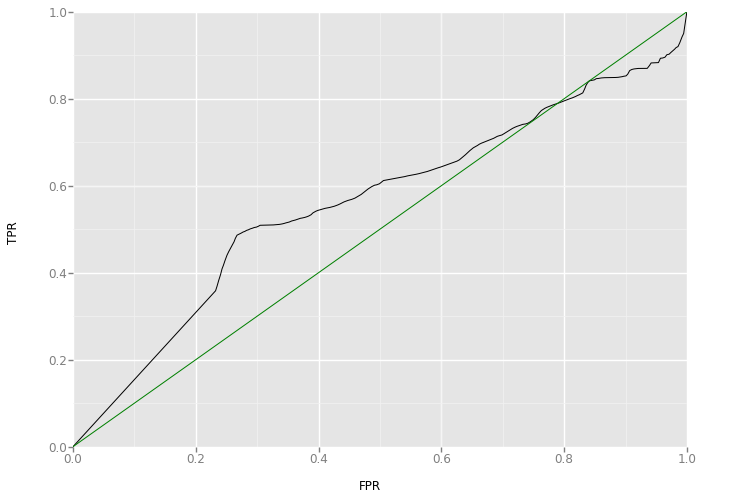

<ggplot: (8761138764785)>

In [193]:
ROC_curve = evaluation.roc.toPandas()

p1 =  ggplot(aes(x="FPR", y="TPR"),data=ROC_curve ) + geom_line() + geom_hline(yintercept = 0.8) \
        + geom_abline(intercept = 0 , slope = 1 ,color ="green") \
       + xlim(0,1) + ylim(0,1) 
p1 

<b> <u>Comments:</u>
<ol> 
<li> In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The Total Operating Characteristic (TOC) expands on the idea of ROC by showing the total information in the two-by-two contingency table for each threshold.</li>
<li>ROC gives only two bits of relative information for each threshold, thus the TOC gives strictly more information than the ROC.The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection[1] in machine learning. The false-positive rate is also known as the fall-out or probability of false alarm[1] and can be calculated as (1 − specificity). The ROC curve is thus the sensitivity as a function of fall-out.</li>
<li>In general, if the probability distributions for both detection and false alarm are known, the ROC curve can be generated by plotting the cumulative distribution function (area under the probability distribution from {\displaystyle -\infty } -\infty  to the discrimination threshold) of the detection probability in the y-axis versus the cumulative distribution function of the false-alarm probability on the x-axis.
ROC analysis provides tools to select possibly optimal models and to discard suboptimal ones independently from (and prior to specifying) the cost context or the class distribution. ROC analysis is related in a direct and natural way to cost/benefit analysis of diagnostic decision making.</li>
</ol>
</b>

In [194]:
evaluation.predictions.show()

+--------+--------------------+-----+--------------------+--------------------+----------+
|      id|            features|label|       rawPrediction|         probability|prediction|
+--------+--------------------+-----+--------------------+--------------------+----------+
| 1002442|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10038883|[NaN,6.0,NaN,2.0,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10044830|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10085608|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10093225|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10100969|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10144730|[5.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|
|10257622|[1.0,NaN,1.0,NaN,...|  0.0|           [NaN,NaN]|           [NaN,NaN]|       0.0|